# Mondo Rare Disease Analysis


Any disease term in Mondo is characterized as 'rare' if the term or its ancestor has modifier MONDO:0021136 'Rare'.

In [1]:
rare_term = 'MONDO:0021136'
disease_susceptibility_term = 'MONDO:0042489'

SUBCLASS_OF = 'subClassOf'
HAS_MODIFIER = 'RO:0002573'

In [2]:
from ontobio.ontol_factory import OntologyFactory
ofa = OntologyFactory()
ont = ofa.create('ontology/mondo.json') # http://purl.obolibrary.org/obo/mondo/releases/2019-09-30/mondo.json
subont = ont.subontology(relations=['subClassOf', 'RO:0002573'])
subclass_subont = ont.subontology(relations=['subClassOf'])

In [3]:
rare_disease_terms = set()

for x in subont.nodes():
    if rare_term in subont.ancestors(x):
        rare_disease_terms.add(x)

In [4]:
print("Number of MONDO terms that are rare disease: {}".format(len(rare_disease_terms)))

Number of MONDO terms that are rare disease: 12970


In [5]:
disease_susceptibility_descendants = subont.descendants(disease_susceptibility_term)
print("Number of MONDO terms that are descendants of MONDO:0042489 'disease susceptibility': {}".format(len(disease_susceptibility_descendants)))

Number of MONDO terms that are descendants of MONDO:0042489 'disease susceptibility': 249


In [6]:
gard_rare_subset = ont.extract_subset('gard_rare')
print("Number of MONDO terms that are in GARD rare subset: {}".format(len(gard_rare_subset)))

Number of MONDO terms that are in GARD rare subset: 3196


In [7]:
rare_disease_terms_leaf_nodes = set()

for term in rare_disease_terms:
    descendants = subont.descendants(term)
    if len(descendants) == 0:
        rare_disease_terms_leaf_nodes.add(term)

In [8]:
from collections import defaultdict

mondo_disease_term = 'MONDO:0000001'
all_disease_descendants = subclass_subont.descendants(mondo_disease_term)

all_leaf_nodes = []
is_leaf = []
is_rare = []
term_xrefs = {}
term_synonyms = {}

for term in all_disease_descendants:
    descendants = subclass_subont.descendants(term)
    if len(descendants) == 0:
        all_leaf_nodes.append(term)
        is_leaf.append(True)
    else:
        is_leaf.append(False)
    if term in rare_disease_terms or term in gard_rare_subset:
        # if term has modifier 'rare disease'
        # OR term is in GARD rare subset
        if term not in disease_susceptibility_descendants:
            # if term is not a descendant of MONDO 'disease susceptibility'
            # then term is rare
            is_rare.append(True)
        else:
            # term is not rare
            is_rare.append(False)
    else:
        # term is not rare
        is_rare.append(False)

    xrefs = ont.xrefs(term)
    term_xrefs[term] = defaultdict(str)
    for xref in xrefs:
        if xref.startswith('GARD:'):
            term_xrefs[term]['GARD'] = xref
        elif xref.startswith('NCIT:'):
            term_xrefs[term]['NCIT'] = xref
        elif xref.startswith('OMIM:'):
            term_xrefs[term]['OMIM'] = xref
        elif xref.startswith('DOID:'):
            term_xrefs[term]['DOID'] = xref
        elif xref.startswith('Orphanet:'):
            term_xrefs[term]['Orphanet'] = xref

    synonyms = [x.val for x in ont.synonyms(term)]
    term_synonyms[term] = synonyms

In [9]:
import pandas as pd
import collections
import itertools

from matplotlib import pyplot as plt

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def makebool(combo, cols):
    return [c in combo for c in cols]

# https://upsetplot.readthedocs.io/en/latest/api.html
import upsetplot as usp
counts_dict = {}

def create_upset(df, cols, count_limit=0, **args):
    ps = powerset(cols)
    global my_data
    counts_by_combo = collections.defaultdict(int)
    for i,r in df.iterrows():
        combo = [r[c] != "" and r[c] != False and r[c] != 0 for c in cols]
        counts_by_combo[tuple(combo)] += 1
    
    for k,v in counts_by_combo.items():
        key = []
        for i in range(0,len(cols)):
            if k[i]:
                key.append(cols[i])
        key_str = '-'.join(key)
        counts_dict[key_str] = v

    counts = []
    boolvecs = []
    for s in ps:
        boolvec = makebool(s, cols)
        c = counts_by_combo[tuple(boolvec)]
        if c > count_limit:
            boolvecs.append(boolvec)
            counts.append(c)
    multiindex = pd.MultiIndex.from_tuples(boolvecs, names=cols)
    upsetdata = pd.Series(counts, index=multiindex).sort_values(ascending=False)
    my_data = upsetdata
    usp.plot(upsetdata, sort_by='cardinality', **args)


In [10]:
d = {
    'class': all_disease_descendants,
    'class_label': [ont.label(x) for x in all_disease_descendants],
    'synonyms': ['|'.join(term_synonyms[x]) for x in all_disease_descendants],
    'GARD': [term_xrefs[x]['GARD'] for x in all_disease_descendants],
    'NCIT': [term_xrefs[x]['NCIT'] for x in all_disease_descendants],
    'OMIM': [term_xrefs[x]['OMIM'] for x in all_disease_descendants],
    'DOID': [term_xrefs[x]['DOID'] for x in all_disease_descendants],
    'Orphanet': [term_xrefs[x]['Orphanet'] for x in all_disease_descendants],
    'is_leaf': is_leaf,
    'is_rare': is_rare,
}
df = pd.DataFrame(data=d)

In [11]:
df

,class,class_label,synonyms,GARD,NCIT,OMIM,DOID,Orphanet,is_leaf,is_rare
0,MONDO:0009111,dihydropyrimidinuria,Dpys deficiency|dihydropyrimidinase deficiency...,GARD:0012347,,OMIM:222748,,Orphanet:38874,True,False
1,MONDO:0015681,childhood disintegrative disorder,dementia infantilis|heller syndrome,GARD:0006040,NCIT:C97164,,,Orphanet:168782,True,True
2,MONDO:0044203,foveal hypoplasia,FVH,,,,,,False,False
3,MONDO:0011216,hemochromatosis type 2A,HJV hemochromatosis type 2|HFE2A|hemochromatos...,,,OMIM:602390,DOID:0111027,,True,True
4,MONDO:0019109,CANOMAD syndrome,chronic ataxic neuropathy ophthalmoplegia M-pr...,GARD:0009778,,,,Orphanet:71279,True,True
5,MONDO:0011567,dilated cardiomyopathy 1K,"cardiomyopathy, dilated, 1K|cardiomyopathy, di...",,,OMIM:605582,DOID:0110437,,True,True
6,MONDO:0021635,neurocristopathy,disorder of neural crest cell development|neur...,,,,,,False,False
7,MONDO:0005179,ovarian adenoma benign,,,,,,,True,False
8,MONDO:0054860,"deafness, autosomal recessive 110","deafness, autosomal recessive 110; DFNB110|DFN...",,,OMIM:618094,,,True,True
9,MONDO:0000640,central nervous system primitive neuroectoderm...,central nervous system primitive neuroectoderm...,,NCIT:C5398,,DOID:0060103,,False,True


In [16]:
df.to_csv('artifacts/all-mondo-disease-terms.tsv', sep='\t', index=False)

### Rare and leaf MONDO terms


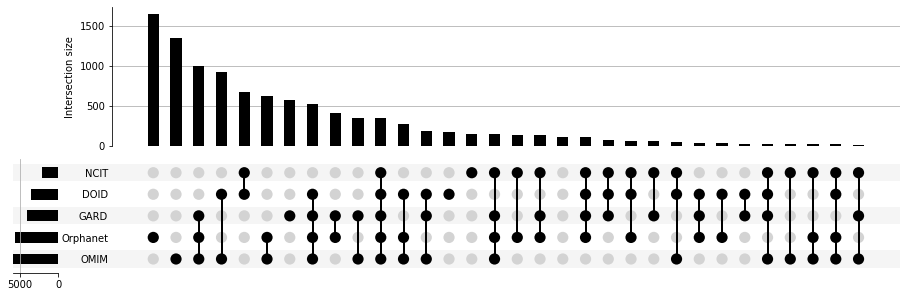

In [17]:
# rare and leaf MONDO terms
df4 = df.loc[(df['is_rare'] == True) & (df['is_leaf'] == True)]
create_upset(df4, ['GARD', 'NCIT', 'OMIM', 'DOID', 'Orphanet'])

In [18]:
df4.to_csv('artifacts/rare-and-leaf-mondo-disease-terms.tsv', sep='\t', index=False)